In [1]:
import struct
from copy import deepcopy

import rospy
import gazebo_msgs.srv
import geometry_msgs.msg
import std_msgs.msg
import baxter_core_msgs.srv

import tf.transformations
import baxter_interface

import numpy as np
from utils import *
from baxter_pickplace_interface import *
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
rospy.init_node("ik_pick_and_place_demo")

limb = "left"
hover_distance = 0.12
pnp = PickAndPlace(limb, hover_distance)
pnp.move_to_start()

Getting robot state... 
Enabling robot... 
[INFO] [1564627019.354235, 2678.298000]: Robot Enabled
Moving the left arm to start pose...
Running. Ctrl-c to quit


In [3]:
rospy.wait_for_service('/gazebo/spawn_sdf_model')
rospy.wait_for_service('/gazebo/spawn_urdf_model')
spawn_sdf = rospy.ServiceProxy('/gazebo/spawn_sdf_model', gazebo_msgs.srv.SpawnModel)
spawn_urdf = rospy.ServiceProxy('/gazebo/spawn_urdf_model', gazebo_msgs.srv.SpawnModel)

camera_quaternion = tf.transformations.quaternion_from_euler(0., np.pi / 2., 0.)
spawn_gazebo_model(spawn_urdf, "realsense", "rs200", 0.65, 0.0, 1.7825, 
                   qx=camera_quaternion[0],qy=camera_quaternion[1],qz=camera_quaternion[2],qw=camera_quaternion[3])
spawn_gazebo_model(spawn_sdf, "cafe_table", "cafe_table", 0.8, 0.0, 0.0)
spawn_gazebo_model(spawn_sdf, "basket", "start_box", 0.65, 0.0, 0.7825)

object_pose_list = []
number_of_object=1
for i in range(number_of_object):
    rnd_x = 0.02*(2.*np.random.uniform()-1.) + 0.65
    rnd_y = 0.02*(2.*np.random.uniform()-1.)
    rnd_z = 1.0
    rnd_roll = 2.*np.pi*np.random.uniform()
    rnd_pitch = 2.*np.pi*np.random.uniform()
    rnd_ywa = 2.*np.pi*np.random.uniform()
    rnd_quaternion = tf.transformations.quaternion_from_euler(rnd_roll,rnd_pitch,rnd_ywa)
    object_pose = spawn_gazebo_model(spawn_sdf, "t_shape", "object"+str(i), 
                                     rnd_x, rnd_y, rnd_z,
                                     rnd_quaternion[0],rnd_quaternion[1],rnd_quaternion[2],rnd_quaternion[3])
    object_pose_list.append(object_pose)

In [4]:
rospy.wait_for_service('/gazebo/get_model_state')
rospy.wait_for_service('/gazebo/set_model_state')
get_model_state = rospy.ServiceProxy("/gazebo/get_model_state", gazebo_msgs.srv.GetModelState)
set_model_state = rospy.ServiceProxy("/gazebo/set_model_state", gazebo_msgs.srv.SetModelState)

highest_object_pose = None
highest_object_name = None
for i in range(number_of_object):
    object_pose = get_gazebo_model_state(get_model_state,"object"+str(i))
    if highest_object_pose is None:
        highest_object_pose = object_pose
        highest_object_name = "object"+str(i)
    elif (highest_object_pose.position.x-0.65)**2 + highest_object_pose.position.y**2 < (object_pose.position.x-0.65)**2 + object_pose.position.y**2:
        highest_object_pose = object_pose
        highest_object_name = "object"+str(i)

In [5]:
file_name = "/home/dof6/.gazebo/models/t_shape/meshes/t_shape.dae"
trimesh_data, _ = load_dae_to_trimesh(file_name)
gripper_contact_list, gripper_quaternion_list, gripper_width_list, quality_list, extra_information_list = sample_antipodal_grasp(trimesh_data, number_of_contact=100, number_of_quaternion=37)

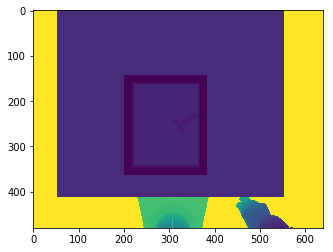

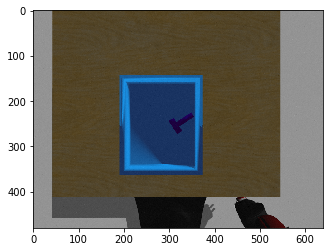

In [6]:
observation = get_rgbd_image()
color_camera_info = observation["color_camera_info"]
depth_camera_info = observation["depth_camera_info"]

plt.figure()
plt.imshow(observation["depth"])
plt.show()

plt.figure()
plt.imshow(observation["color"])
plt.show()

In [7]:
for gripper_contact, gripper_quaternion, quality in zip(gripper_contact_list, gripper_quaternion_list, quality_list):
    print(highest_object_name)
    print(quality)
    if quality:
        eef_position = position2list(highest_object_pose.position) + rotate_quaternion_vector(highest_object_pose.orientation, gripper_contact)
        eef_quaternion = tf.transformations.quaternion_multiply(quaternion2list(highest_object_pose.orientation), gripper_quaternion)
        approaching_axis = np.matmul(tf.transformations.quaternion_matrix(eef_quaternion)[:3,:3],[0.,0.,1.])
        print(approaching_axis[2])
        if approaching_axis[2] < np.cos(11*np.pi/12):
            modified_position = eef_position + 0.0*approaching_axis
            grasp_pose = geometry_msgs.msg.Pose()
            grasp_pose.position.x = modified_position[0]
            grasp_pose.position.y = modified_position[1]
            grasp_pose.position.z = modified_position[2] - 0.9115
            grasp_pose.orientation.x = eef_quaternion[0]
            grasp_pose.orientation.y = eef_quaternion[1]
            grasp_pose.orientation.z = eef_quaternion[2]
            grasp_pose.orientation.w = eef_quaternion[3]

            pnp.move_to_start(open_gripper=True)
            pnp.move_to_ready(open_gripper=True)
            pnp.pick(grasp_pose)
            pnp.move_to_ready(open_gripper=False)
            pnp.move_to_middle(open_gripper=False)
            pnp.move_to_start(open_gripper=False)
            grasp_result = get_grasp_result(highest_object_name)
            if grasp_result:
                break

object0
1.0
9.959459732478138e-06
object0
1.0
1.673707666038915e-05
object0
1.0
2.3006145983606174e-05
object0
1.0
2.8576185202966453e-05
object0
1.0
3.32779514948256e-05
object0
1.0
3.6968584070484756e-05
object0
1.0
3.953594492556167e-05
object0
1.0
4.0902026100617106e-05
object0
1.0
4.102531990977931e-05
object0
1.0
3.990208013350885e-05
object0
1.0
3.7566435843183754e-05
object0
1.0
3.4089354410378606e-05
object0
1.0
2.9576485193238793e-05
object0
1.0
2.416494943989836e-05
object0
1.0
1.801917392633967e-05
object0
1.0
1.1325894930233615e-05
object0
1.0
4.288484348330401e-06
object0
1.0
-2.8792296599966516e-06
object0
1.0
-9.959459732367115e-06
object0
1.0
-1.6737076660777728e-05
object0
1.0
-2.300614598382822e-05
object0
1.0
-2.8576185203021964e-05
object0
1.0
-3.3277951494770086e-05
object0
1.0
-3.696858407054027e-05
object0
1.0
-3.953594492533963e-05
object0
1.0
-4.090202610051996e-05
object0
1.0
-4.102531990979319e-05
object0
1.0
-3.99020801334915e-05
object0
1.0
-3.756643584351

KeyboardInterrupt: 

[[ 0.     -1.      0.      0.65  ]
 [-1.      0.      0.     -0.03  ]
 [ 0.      0.     -1.      1.7825]
 [ 0.      0.      0.      1.    ]]
[[ 0.     -1.      0.      0.65  ]
 [-1.      0.      0.     -0.046 ]
 [ 0.      0.     -1.      1.7825]
 [ 0.      0.      0.      1.    ]]


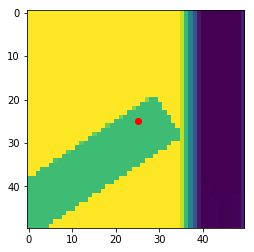

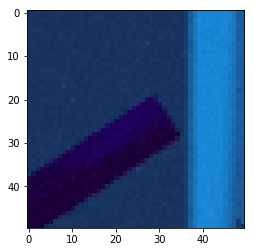

In [14]:
cropping_size = 25

depth_cam_rotation_matrix = np.zeros([4,4])
depth_cam_rotation_matrix[1,0] = -1.
depth_cam_rotation_matrix[0,1] = -1.
depth_cam_rotation_matrix[2,2] = -1.
depth_cam_rotation_matrix[3,3] = 1.
depth_cam_rotation_matrix[0,3] = .65
depth_cam_rotation_matrix[1,3] =-.03
depth_cam_rotation_matrix[2,3] = 1.7825
print(depth_cam_rotation_matrix)

color_cam_rotation_matrix = np.zeros([4,4])
color_cam_rotation_matrix[1,0] = -1.
color_cam_rotation_matrix[0,1] = -1.
color_cam_rotation_matrix[2,2] = -1.
color_cam_rotation_matrix[3,3] = 1.
color_cam_rotation_matrix[0,3] = .65
color_cam_rotation_matrix[1,3] =-.046
color_cam_rotation_matrix[2,3] = 1.7825
print(color_cam_rotation_matrix)

depth_cam_scaled_eef_position = np.matmul(np.linalg.inv(depth_cam_rotation_matrix[:3,:3]),modified_position - depth_cam_rotation_matrix[:3,3])
depth_cam_scaled_eef_position = depth_cam_scaled_eef_position/depth_cam_scaled_eef_position[2]

color_cam_scaled_eef_position = np.matmul(np.linalg.inv(color_cam_rotation_matrix[:3,:3]),modified_position - color_cam_rotation_matrix[:3,3])
color_cam_scaled_eef_position = color_cam_scaled_eef_position/color_cam_scaled_eef_position[2]

K = np.asarray(depth_camera_info.K).reshape([3,3])
projected_depth_cam_eef_position = np.matmul(K,depth_cam_scaled_eef_position)
K = np.asarray(color_camera_info.K).reshape([3,3])
projected_color_cam_eef_position = np.matmul(K,color_cam_scaled_eef_position)

depth_cam_center_x = int(projected_depth_cam_eef_position[0])
depth_cam_center_y = int(projected_depth_cam_eef_position[1])

color_cam_center_x = int(projected_color_cam_eef_position[0])
color_cam_center_y = int(projected_color_cam_eef_position[1])

cropped_depth_image = observation["depth"][depth_cam_center_y-cropping_size:depth_cam_center_y+cropping_size,depth_cam_center_x-cropping_size:depth_cam_center_x+cropping_size,np.newaxis]
cropped_color_image = observation["color"][color_cam_center_y-cropping_size:color_cam_center_y+cropping_size,color_cam_center_x-cropping_size:color_cam_center_x+cropping_size,:]

plt.figure()
plt.imshow(cropped_depth_image[:,:,0])
plt.plot(cropping_size,cropping_size,'ro')
plt.show()

plt.figure()
plt.imshow(cropped_color_image)
plt.show()